In [467]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, glob

In [468]:
from IPython.display import display_html

#  command for viewing dataframes side by side
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Goal: Determine Fragment Analysis Sensitivity to Parameters
Parameters are:
- Cutoff
- Easy Limit
- Hard Limit

Fragment analysis  has been run on *Lipophilicity-ID.csv* dataset with systematic variations in the above parameters.


## Metrics

I will use number of relationships and *difficulty* as metrics of the analysis stability.  Specifically, I am looking at
how these metrics change with respect to the above parameters.  Is it a smooth change?  Does the metric have a sharp
change at some point in the parameter space?

I expect there to be a semi-sharp change in number of relationships as outliers become included in the fragment analysis.

In [469]:
def df_cleanup(df):
    df = df.rename(columns={'number_of_rel': 'rels'})
    df = df.drop(columns=['sum_difficulty'])
    return df

In [470]:
path = 'results/'
prefix = 'FragAnalysis_Lipophilicity-ID'
cut_str = '0.775'
easy_str = '0.1'
hard_str = '0.1'
file_str = path + prefix + '_' + cut_str + '_' + easy_str + '_' +hard_str +'.csv'
print(file_str)

results/FragAnalysis_Lipophilicity-ID_0.775_0.1_0.1.csv


In [471]:
a = df_cleanup(pd.read_csv(file_str))
a.sort_values(by="avg_difficulty", ascending=False).head(15)

,Unnamed: 0,fragment,rels,avg_difficulty
428,428,CC(<-C(=O)O>)<-N>,1,3.334416
429,429,CC(<-C(=O)O>)<-N>C,1,3.334416
430,430,C(<-C(=O)O>)<-N>CO,1,3.334416
431,431,COP(<-O>)(<-O>)<=O>,1,3.334416
432,432,CC(<-C(=O)O>)<-N>CO,1,3.334416
433,433,C(<-C(=O)O>)<-N>COP(<-O>)(<-O>)<=O>,1,3.334416
434,434,CC(<-C(=O)O>)<-N>COP(<-O>)(<-O>)<=O>,1,3.334416
96,96,OP(<-O>)(<-O>)<=O>,2,2.852950
463,463,c[n+]c(C)n,1,2.791796
458,458,C[n+]cNC,1,2.791796


In [472]:
rels_diff = a.sort_values(by="avg_difficulty", ascending=False)["rels"].iloc[0]
print("Rels of highest difficulty fragment:", rels_diff)

diff_max = a.sort_values(by="avg_difficulty", ascending=False)["avg_difficulty"].iloc[0]
print("Highest Difficulty:", diff_max)

rels_max = a.sort_values(by="rels", ascending=False)["rels"].iloc[0]
print("Highest number of Relationships:", rels_max)

diff_rels = a.sort_values(by="rels", ascending=False)["avg_difficulty"].iloc[0]
print('Difficulty of Fragment with most relationships:',diff_rels)

fCount = a.shape[0]
print('Number of fragments returned:',fCount)

Rels of highest difficulty fragment: 1
Highest Difficulty: 3.3344159115007703
Highest number of Relationships: 5
Difficulty of Fragment with most relationships: 1.3952060294730335
Number of fragments returned: 1854


In [473]:
def getFiles():
    filenames = [] # empty list for running list of files
    for file in glob.glob(path + prefix +'*.csv'): # get every .out file in current working directory
        # print(file)
        filenames.append(file) # add file name to list



    file_df = pd.DataFrame([], columns =['Data', 'Cutoff', 'Easy_Limit', 'Hard_Limit', ])


    #define regex pattern
    rx_file = re.compile(r'''FragAnalysis_(?P<data>Lipophilicity-ID)_(?P<cutoff>.*?)_(?P<easy>.*?)_(?P<hard>.*?).csv''')

    for file in filenames:
        # search file for regex pattern
        file_res = rx_file.search(file)

        #save info found in regex search to variables
        data = file_res.group('data')

        cutoff = float(file_res.group('cutoff'))
        easy = float(file_res.group('easy'))
        hard = float(file_res.group('hard'))

        df = pd.read_csv(file)
        if df.empty:  # no fragments returned
            info = {'Data': data, # The dataset
                'Cutoff': cutoff,  # The cutoff parameter
                'Easy_Limit': easy,  # The number of Easy fragments
                'Hard_Limit': hard,  # The number of Hard fragments
                'Max_Rels': 0,  # Max number of relationships on a hard frag
                'Max_Rels_Difficulty': 0, # the difficulty of must frequent frag
                'Max_Difficulty': 0,  # highest difficulty of frag
                'Max_Difficulty_Rels': 0,  # number of rels for most difficult frag
                'Frag_Count': 0  # how many fragments the analysis returned

                }
        else:
            df = df_cleanup(df)
            rels_diff = df.sort_values(by="avg_difficulty", ascending=False)["rels"].iloc[0]
            diff_max = df.sort_values(by="avg_difficulty", ascending=False)["avg_difficulty"].iloc[0]
            rels_max = df.sort_values(by="rels", ascending=False)["rels"].iloc[0]
            diff_rels = df.sort_values(by="rels", ascending=False)["avg_difficulty"].iloc[0]
            fCount = df.shape[0]

            info = {'Data': data, # The dataset
                    'Cutoff': cutoff,  # The cutoff parameter
                    'Easy_Limit': easy,  # The number of Easy fragments
                    'Hard_Limit': hard,  # The number of Hard fragments
                    'Max_Rels': rels_max,  # Max number of relationships on a hard frag
                    'Max_Rels_Difficulty': diff_rels, # the difficulty of must frequent frag
                    'Max_Difficulty': diff_max,  # highest difficulty of frag
                    'Max_Difficulty_Rels': rels_diff,  # number of rels for most difficult frag
                    'Frag_Count': fCount  # how many fragments the analysis returned
                    }
        file_df = file_df.append(info, ignore_index=True)
        # print(data, cutoff, easy, hard)






    return filenames, file_df

In [474]:
files, df = getFiles()
df.sort_values(by=['Cutoff', 'Easy_Limit', 'Hard_Limit']).head(15)

,Data,Cutoff,Easy_Limit,Hard_Limit,Frag_Count,Max_Difficulty,Max_Difficulty_Rels,Max_Rels,Max_Rels_Difficulty
2635,Lipophilicity-ID,0.5,0.05,0.050,3295.0,3.143136,1.0,13.0,1.246629
2520,Lipophilicity-ID,0.5,0.05,0.075,7161.0,3.334416,1.0,13.0,1.246629
3137,Lipophilicity-ID,0.5,0.05,0.100,8430.0,3.334416,1.0,13.0,1.246629
5952,Lipophilicity-ID,0.5,0.05,0.125,8430.0,3.334416,1.0,13.0,1.246629
5953,Lipophilicity-ID,0.5,0.05,0.150,8430.0,3.334416,1.0,13.0,1.246629
2561,Lipophilicity-ID,0.5,0.05,0.175,8430.0,3.334416,1.0,13.0,1.246629
1282,Lipophilicity-ID,0.5,0.05,0.200,8430.0,3.334416,1.0,13.0,1.246629
265,Lipophilicity-ID,0.5,0.05,0.225,8430.0,3.334416,1.0,13.0,1.246629
5667,Lipophilicity-ID,0.5,0.05,0.250,8430.0,3.334416,1.0,13.0,1.246629
6431,Lipophilicity-ID,0.5,0.05,0.275,8430.0,3.334416,1.0,13.0,1.246629


In [475]:
df.sort_values(by='Max_Difficulty').head(15)

,Data,Cutoff,Easy_Limit,Hard_Limit,Frag_Count,Max_Difficulty,Max_Difficulty_Rels,Max_Rels,Max_Rels_Difficulty
5296,Lipophilicity-ID,0.950,0.250,0.050,0.0,0.0,0.0,0.0,0.0
63,Lipophilicity-ID,0.975,0.450,0.050,0.0,0.0,0.0,0.0,0.0
6127,Lipophilicity-ID,0.950,0.375,0.050,0.0,0.0,0.0,0.0,0.0
4243,Lipophilicity-ID,0.975,0.475,0.050,0.0,0.0,0.0,0.0,0.0
5412,Lipophilicity-ID,0.975,0.350,0.075,0.0,0.0,0.0,0.0,0.0
2974,Lipophilicity-ID,0.950,0.500,0.050,0.0,0.0,0.0,0.0,0.0
2956,Lipophilicity-ID,0.975,0.300,0.050,0.0,0.0,0.0,0.0,0.0
1856,Lipophilicity-ID,0.950,0.175,0.050,0.0,0.0,0.0,0.0,0.0
3417,Lipophilicity-ID,0.975,0.325,0.075,0.0,0.0,0.0,0.0,0.0
489,Lipophilicity-ID,0.975,0.200,0.075,0.0,0.0,0.0,0.0,0.0


## Plots

The data is collected.  Lets see what we can plot from here.
First, lets look at *cutoff* and *Max_Difficulty*


In [476]:
def plotter(x, y, filename=None, xlabel='', ylabel=''):
    """
    General plotting function for creating an XY scatter plot.
    Accepts x-axis data and y-axis data as (numpy or pd.Series or lists?)
    Returns graph object.  If filename keyword is given, will save to file (PNG)
    ____________________________
    Keyword Arguments
    filename:  None or string. Default = None.  Specify filename for saving to PNG file.  Do not include extension.
    xlabel: string. Default = ''.  X-axis label.
    ylabel: string. Default = ''.  Y-axis label.

    """

    plt.rcParams['figure.figsize'] = [12, 9]
    plt.style.use('bmh')
    fig, ax = plt.subplots()
    plt.plot(x, y, 'o')
    # ax = plt.axes()
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(filename)
    # ax.legend(prop={'size': 16}, facecolor='w', edgecolor='k', shadow=True)
    fig.patch.set_facecolor('blue')  # Will change background color
    fig.patch.set_alpha(0.0)  # Makes background transparent

    if filename is not None:
        plt.savefig(filename + '.png')

    plt.show()

def series_plotter(data, filename=None, xlabel='', ylabel=''):
    """
    General plotting function for creating an XY scatter plot.
    Accepts x-axis data and y-axis data as dictionary of tupled series.
    Returns graph object.  If filename keyword is given, will save to file (PNG)
    ____________________________
    Keyword Arguments
    filename:  None or string. Default = None.  Specify filename for saving to PNG file.  Do not include extension.
    xlabel: string. Default = ''.  X-axis label.
    ylabel: string. Default = ''.  Y-axis label.

    """
    plt.rcParams['figure.figsize'] = [12, 9]
    plt.style.use('bmh')
    fig, ax = plt.subplots()

    for key, value in data.items():
        x = value[0]
        y = value[1]
        plt.plot(x, y, value[2], label=key)


    # ax = plt.axes()
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(filename)
    plt.legend()
    # ax.legend(prop={'size': 16}, facecolor='w', edgecolor='k', shadow=True)
    fig.patch.set_facecolor('blue')  # Will change background color
    fig.patch.set_alpha(0.0)  # Makes background transparent

    if filename is not None:
        plt.savefig(filename + '.png')

    plt.show()

### Cutoff vs Max Difficulty
Holding the *Easy_Limit* and *Hard_Limit* constant at 0.1 (top 10%) for this analysis.
We could have multiple series of different values of these parameters.

In [477]:
df2 = df.loc[(df['Easy_Limit'] == 0.1) & (df['Hard_Limit'] == 0.1)]
# df2.head(15)

In [478]:
df3 = df.loc[(df['Easy_Limit'] == 0.5) & (df['Hard_Limit'] == 0.5)]
# df3.head(15)

In [479]:
df4 = df.loc[(df['Easy_Limit'] == 0.1) & (df['Hard_Limit'] == 0.5)]
# df4.head(15)

In [480]:
df5 = df.loc[(df['Easy_Limit'] == 0.5) & (df['Hard_Limit'] == 0.1)]
df6 = df.loc[(df['Easy_Limit'] == 0.25) & (df['Hard_Limit'] == 0.25)]

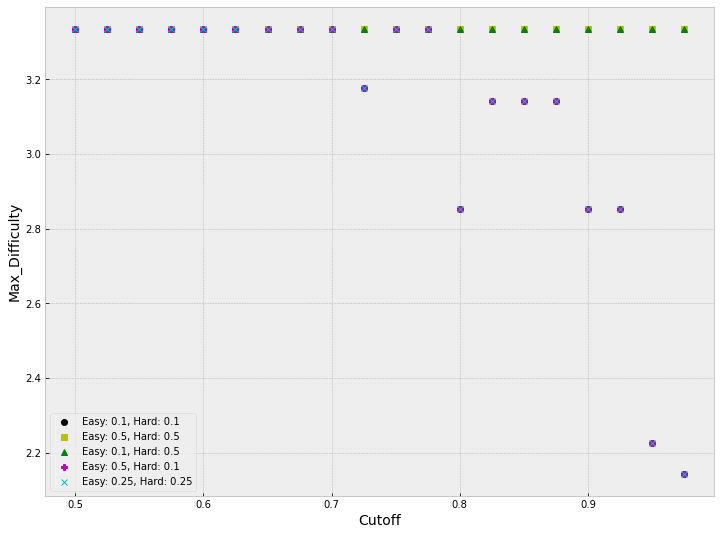

In [481]:
# plotter(df2['Cutoff'], df2['Max_Difficulty'], xlabel='Cutoff', ylabel= 'Max_Difficulty')
data = {'Easy: 0.1, Hard: 0.1': (df2['Cutoff'], df2['Max_Difficulty'], 'ko'),
        'Easy: 0.5, Hard: 0.5': (df3['Cutoff'], df3['Max_Difficulty'], 'ys'),
        'Easy: 0.1, Hard: 0.5': (df4['Cutoff'], df4['Max_Difficulty'], 'g^'),
        'Easy: 0.5, Hard: 0.1': (df5['Cutoff'], df5['Max_Difficulty'], 'mP'),
        'Easy: 0.25, Hard: 0.25': (df5['Cutoff'], df5['Max_Difficulty'], 'cx')
        }
series_plotter(data, xlabel='Cutoff', ylabel= 'Max_Difficulty')

### Cutoff vs Max Relationships

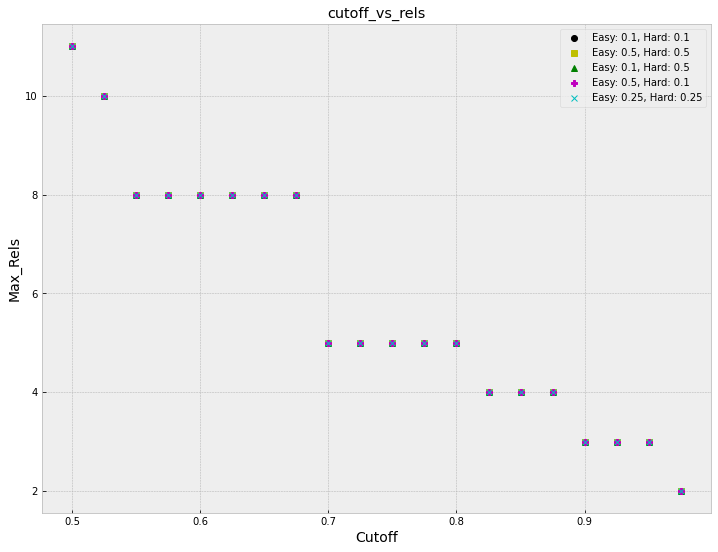

In [569]:
data2 = {'Easy: 0.1, Hard: 0.1': (df2['Cutoff'], df2['Max_Rels'], 'ko'),
        'Easy: 0.5, Hard: 0.5': (df3['Cutoff'], df3['Max_Rels'], 'ys'),
        'Easy: 0.1, Hard: 0.5': (df4['Cutoff'], df4['Max_Rels'], 'g^'),
        'Easy: 0.5, Hard: 0.1': (df5['Cutoff'], df5['Max_Rels'], 'mP'),
        'Easy: 0.25, Hard: 0.25': (df5['Cutoff'], df5['Max_Rels'], 'cx')
        }
series_plotter(data2, xlabel='Cutoff', ylabel= 'Max_Rels',filename='cutoff_vs_rels')

## Surface of how many fragments are returned by the analysis
Lets fix *Cutoff* and look at the effect of the *Limits*
I may try to make a slider of this to change cutoff...

In [562]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def surface(x,y,z, xlabel='', ylabel='', zlabel='', ang = 300, filename=None):
    plt.rcParams['figure.figsize'] = [12, 9]
    plt.style.use('bmh')
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_trisurf(x, y, z, cmap=cm.plasma, linewidth=0, antialiased=True)
    # fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    ax.set_zlabel(zlabel, fontsize=14)
    ax.view_init(elev=25., azim= ang)
    fig.patch.set_facecolor('blue')  # Will change background color
    fig.patch.set_alpha(0.0)

    if filename is not None:
        plt.savefig(filename + '.png')

    plt.show()

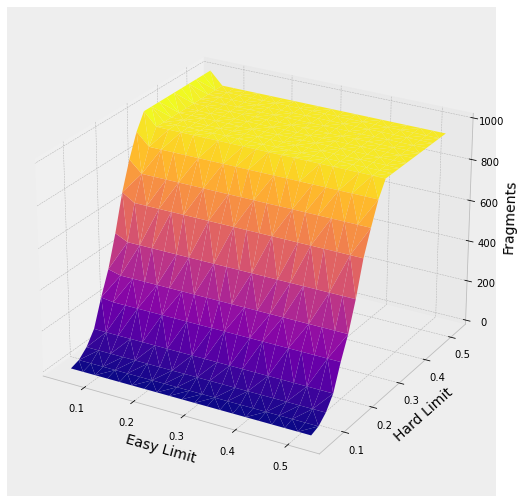

In [559]:
sData = df.loc[(df['Cutoff'] == 0.95)]

# Use azim = 300 for good graph
surface(sData['Easy_Limit'], sData['Hard_Limit'], sData['Frag_Count'],
        xlabel='Easy Limit', ylabel="Hard Limit",zlabel='Fragments', ang=300,
        filename='easy_vs_hard')

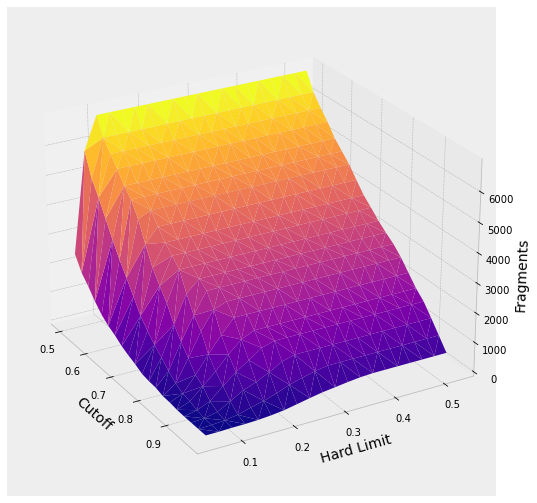

In [567]:
sData2 = df.loc[(df['Easy_Limit'] == 0.15)]
# print(sData['Frag_Count'])
surface(sData2['Cutoff'], sData2['Hard_Limit'], sData2['Frag_Count'],
        xlabel='Cutoff', ylabel="Hard Limit",zlabel='Fragments', ang=330,
        filename='cutoff_vs_hard')

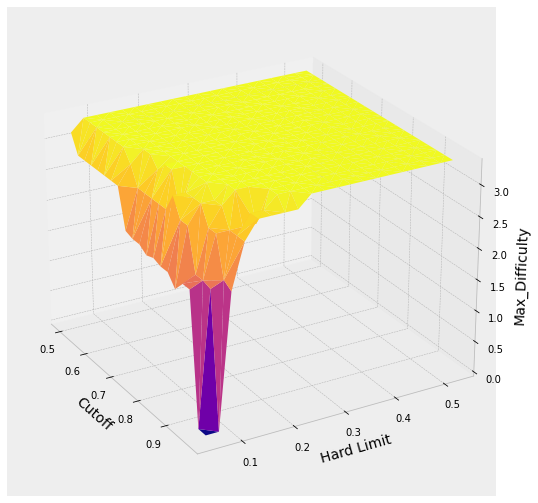

In [568]:
surface(sData2['Cutoff'], sData2['Hard_Limit'], sData2['Max_Difficulty'],
        xlabel='Cutoff', ylabel="Hard Limit",zlabel='Max_Difficulty', ang=330,
        filename='cutoff_vs_hard_diff')

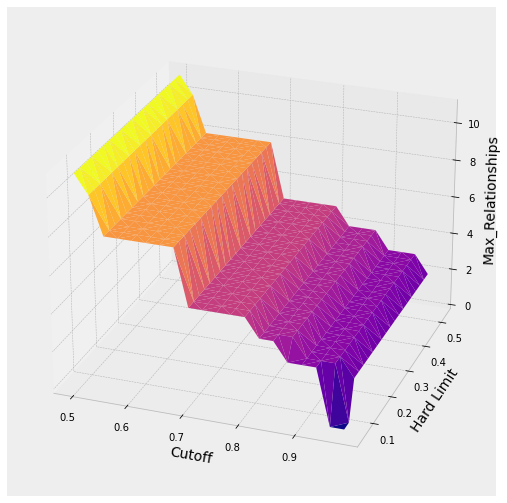

In [572]:
surface(sData2['Cutoff'], sData2['Hard_Limit'], sData2['Max_Rels'],
        xlabel='Cutoff', ylabel="Hard Limit",zlabel='Max_Relationships', ang=290,
        filename='cutoff_vs_hard_rels')